**This kernel is used for training our models. In the end, we went with an ensemble of 15 models similar to the one trained here.**

**Their CV are all above 0.86 and 5-folds LB varies between 0.71 and 0.72**

For our solution writeup, please check : https://www.kaggle.com/c/freesound-audio-tagging-2019/discussion/95409#latest-551352

# Initialization

## Imports

In [1]:
import re
import gc
import os
import time
import pywt
import pickle
import random
import operator
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import *
from collections import Counter
from sklearn.model_selection import *
from tqdm import tqdm_notebook as tqdm
from keras.utils import to_categorical
from multiprocessing import Pool, cpu_count
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
from torch.optim.lr_scheduler import * 
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

import librosa
import librosa.display


begin = time.time()
sns.set_style('white')
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

print("Number of available cpu cores: {}".format(cpu_count()))

Using TensorFlow backend.


Number of available cpu cores: 2


## Seeding

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.set_random_seed(seed)

In [3]:
seed = 2019
seed_everything(seed)

In [4]:
N_JOBS = cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)
DataLoader = partial(DataLoader, num_workers=N_JOBS)

## Load Data

In [5]:
DATA_PATH = '../input/freesound-audio-tagging-2019/'
TRAIN_CURATED_PATH = DATA_PATH + 'train_curated/'
TRAIN_NOISY_PATH = DATA_PATH + 'train_noisy/'
TEST_PATH = DATA_PATH + 'test/'

In [6]:
df_train = pd.read_csv(DATA_PATH + 'train_curated.csv')
df_noisy = pd.read_csv(DATA_PATH + 'train_noisy.csv')
df_test = pd.read_csv(DATA_PATH + 'sample_submission.csv')

df_train.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [7]:
labels = list(df_test.columns[1:])
num_classes = len(labels)

print("Number of classes :", num_classes)

Number of classes : 80


*Removing "corrupted" files*

In [8]:
to_remove = ["f76181c4.wav", "77b925c2.wav", "6a1f682a.wav", "c7db12aa.wav", "7752cc8a.wav", "1d44b0bd.wav"]

for i in df_train.copy().index:
    if df_train['fname'][i] in to_remove:
        df_train.drop(i, inplace=True)
        
df_train = df_train.reset_index(drop=True)

*Restraining noisy data to samples with only one label*

In [9]:
df_noisy["nb_labels"] = df_noisy["labels"].apply(lambda x: len(x.split(',')))
df_noisy = df_noisy[df_noisy["nb_labels"] == 1].copy().reset_index(drop=True)

# Signal Processing

## Config

In [10]:
class config:
    sampling_rate = 44100  # 44.1 kHz
    duration = 4 #2 # Minimum length for short samples (seconds)
    samples = sampling_rate * duration # Minimum sample size
    
    top_db = 60 # Noise filtering, default = 60
    
    # Frequencies kept in spectrograms
    fmin = 20
    fmax =  sampling_rate // 2  # Shannon theorem

    # Spectrogram parameters
    n_mels = 64 # = spec_height
    n_fft = n_mels * 30 # Size of fft window - smooths the spectrogram
    spec_min_width = 256 #128
    x_mean,x_std = -35.7, 21.6
    hop_length = duration * sampling_rate // spec_min_width + 1 # Number of samples between each frame - impacts y size of spectrogram

## Read Audio

In [11]:
def read_audio(pathname, conf, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if len(y) > 0: # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data: y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

## MEL Spectrogram
The three chanel mode adds first and second or delta to the data. It did not improve the results.

In [12]:
def audio_to_melspectrogram(audio, config, three_chanels=False):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=config.sampling_rate,
                                                 n_mels=config.n_mels,
                                                 hop_length=config.hop_length,
                                                 n_fft=config.n_fft,
                                                 fmin=config.fmin,
                                                 fmax=config.fmax)
    logmel = librosa.power_to_db(spectrogram).astype(np.float32)
    
    if three_chanels:
        return np.array([logmel, librosa.feature.delta(logmel), librosa.feature.delta(logmel, order=2)])
    else:
        return logmel

## Normalize
We can either use individual image statistics or statistics computed on train data.

In [13]:
def normalize(X, mean=None, std=None):
    mean = mean or X.mean()
    std = std or (X-X.mean()).std()
    return ((X - mean)/std).astype(np.float16)

# Labels

In [14]:
def get_labels(df, labels):
    mapping = {label:i for i, label in enumerate(labels)}
    y = np.zeros((len(df), len(labels)))
    all_labels = df['labels'].apply(lambda x: x.split(','))
    for i, label in enumerate(all_labels):
        for l in label:
            y[i, mapping[l]] = 1
    return y.astype(int)

In [15]:
y_train = get_labels(df_train, labels)

## Select best noisy samples

We load predictions that were computed using a model that was trained only on curated data. The idea is to keep the ones that were the most correctly predicted, using the log loss as metric. As some class were better predicted than others, we restrict the number of added samples to 50 per class.

In [16]:
scores_noisy = np.load("../input/fat-cp/scores.npy")
y_noisy = get_labels(df_noisy, labels)

In [17]:
def sort_by_loss(y_noisy, scores_noisy):
    losses_dic = {i : log_loss(y_noisy[i], scores_noisy[i]) for i in range(scores_noisy.shape[0])}
    sorted_dic = sorted(losses_dic.items(), key=operator.itemgetter(1))
    return sorted_dic

In [18]:
sorted_by_loss = sort_by_loss(y_noisy, scores_noisy)

In [19]:
def select_noisy(sorted_by_loss, nb_noisy, max_per_class=50):
    selected = np.array(sorted_by_loss)[:nb_noisy, 0].astype(int)
    to_keep = []
    counts = {}
    for s in selected:
        l = df_noisy["labels"][s]
        try:
            counts[l] += 1
        except:
            counts[l] = 0
        if counts[l] < max_per_class:
            to_keep.append(s)
            
        
    return df_noisy.iloc[to_keep].reset_index(drop=True)
    
    df_noisy_selected

In [20]:
nb_noisy = 5000

In [21]:
df_noisy_selected = select_noisy(sorted_by_loss, nb_noisy, max_per_class=50)
y_noisy = get_labels(df_noisy_selected, labels)

## Input data

In [22]:
three_chanels = False
crop = False

In [23]:
def process(df, path, config, crop=False, three_chanels=False):
    X = []
    for i in df.index:
        signal = read_audio(path + df['fname'][i], config, crop)
        X.append(normalize(audio_to_melspectrogram(signal, config), config.x_mean, config.x_std)) #normalize based on global statistics
        #X.append(normalize(audio_to_melspectrogram(signal, config))) #normalize based on individual statistics
    return X

In [24]:
# df_train = df_train.head(100)
# df_test = df_test.head(100)
# df_noisy_selected = df_noisy_selected.head(100)

In [25]:
%%time
X_train = process(df_train, TRAIN_CURATED_PATH, config, crop=crop, three_chanels=three_chanels)
X_noisy = process(df_noisy_selected, TRAIN_NOISY_PATH, config, crop=crop, three_chanels=three_chanels)
X_test = process(df_test, TEST_PATH, config, three_chanels=three_chanels)

CPU times: user 10min 3s, sys: 8min 7s, total: 18min 11s
Wall time: 9min 48s


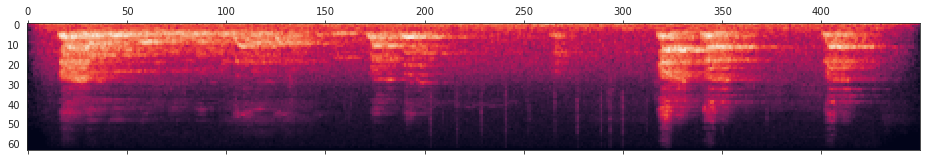

In [26]:
plt.matshow(X_train[0].astype(np.float32))
plt.show()

## Datasets

### Augmentation
We augment spectrograms by hiding random time & frequency intervals

In [27]:
def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):
    spec = spec.copy()
    for i in range(num_mask):
        num_freqs, num_frames = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * num_freqs)
        num_frames_to_mask = int(time_percentage * num_frames)
        
        t0 = int(np.random.uniform(low=0.0, high=num_frames - num_frames_to_mask))
        f0 = int(np.random.uniform(low=0.0, high=num_freqs - num_freqs_to_mask))
        
        spec[:, t0:t0 + num_frames_to_mask] = 0      
        spec[f0:f0 + num_freqs_to_mask, :] = 0 
        
    return spec

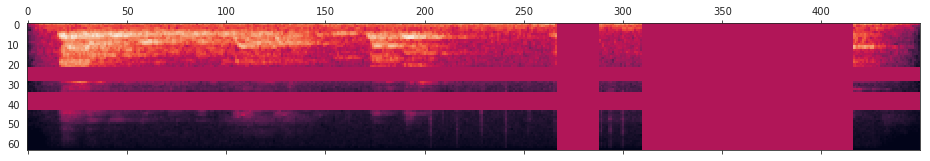

In [28]:
plt.matshow(spec_augment(X_train[0].astype(np.float32)))
plt.show()

### Usual transforms
Only the conversion to tensor is kept, we also tried flipping and resized cropping.

In [29]:
transforms_dict = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'viz': transforms.Compose([
    ]),
}

### Train

In [30]:
class FATDatasetTrain(Dataset):
    def __init__(self, mels, transforms, y, apply_spec_aug=False):
        super().__init__()
        self.mels = mels
        self.labels = y
        self.transforms = transforms
        self.apply_spec_aug = apply_spec_aug
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        data = self.mels[idx].astype(np.float32)
        base_dim,time_dim = data.shape
        crop = random.randint(0, max(time_dim - config.spec_min_width,0))
        data = data[0:base_dim,crop:crop + config.spec_min_width]
        
        if self.apply_spec_aug: 
            data = spec_augment(data)

        data = np.expand_dims(data, axis=2)
        data = self.transforms(data)
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        return data, label

### Test + TTA
TTA helped to fight instability, it worked well for us.

In [31]:
class FATDatasetTest(Dataset):
    def __init__(self, mels, transforms, y=None, nb_tta=5):
        super().__init__()
        self.mels = mels
        self.transforms = transforms
        self.tta = nb_tta
        if y is None:
            self.y = np.zeros(len(self.mels))
        else:
            self.y = y
        
    def __len__(self):
        return len(self.mels) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.mels)
        
        data = self.mels[new_idx].astype(np.float32)#/255.0
        base_dim,time_dim = data.shape
        crop = random.randint(0, max(time_dim - config.spec_min_width,0))
        data = data[0:base_dim,crop:crop + config.spec_min_width]
        data = np.expand_dims(data, axis=2)
        data = self.transforms(data)
        
        return data, self.y[new_idx]

Input shape :  (64, 256)


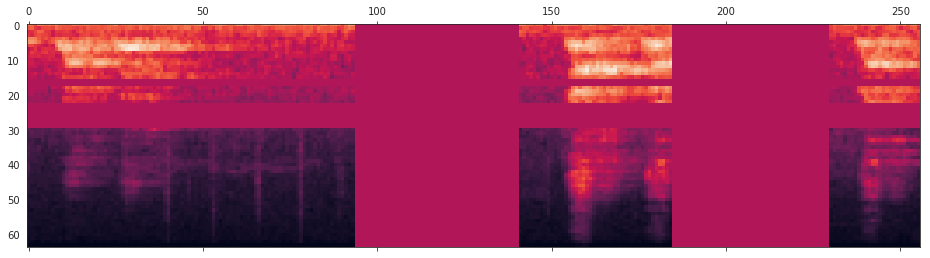

In [32]:
dataset = FATDatasetTrain(X_train[:10], transforms_dict['viz'], y_train[:10], apply_spec_aug=True)
print('Input shape : ', dataset[0][0].squeeze().shape)
plt.matshow(dataset[0][0].squeeze())
plt.show()

# Modeling

## Tools

### Adaptative Pooling

In [33]:
def adaptive_concat_pool2d(x, sz=(1,1)):
    out1 = F.adaptive_avg_pool2d(x, sz).view(x.size(0), -1)
    out2 = F.adaptive_max_pool2d(x, sz).view(x.size(0), -1)
    return torch.cat([out1, out2], 1)

### ConvBlock
Adapted from https://www.kaggle.com/mhiro2/simple-2d-cnn-classifier-with-pytorch

In [34]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pool=True):
        super().__init__()
        
        padding = kernel_size // 2
        self.pool = pool
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels + in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x): # x.shape = [batch_size, in_channels, a, b]
        x1 = self.conv1(x)
        x = self.conv2(torch.cat([x, x1],1))
        if(self.pool): x = F.avg_pool2d(x, 2)
        return x   # x.shape = [batch_size, out_channels, a//2, b//2]

## Models

In [35]:
class Classifier_M1(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(512*2),
            nn.Linear(512*2, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes),
        )

    def forward(self, x): # batch_size, 3, a, b
        x = self.conv(x)  # batch_size, 512, a//16, b//16
        x = self.fc(adaptive_concat_pool2d(x))
        return x

In [36]:
class Classifier_M2(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv1 = ConvBlock(1,64)
        self.conv2 = ConvBlock(64,128)
        self.conv3 = ConvBlock(128,256)
        self.conv4 = ConvBlock(256,512,pool=False)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(1792),
            nn.Linear(1792, 256),
            nn.PReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes),
        )

    def forward(self, x): # batch_size, 3, a, b
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        #pyramid pooling
        x = torch.cat([adaptive_concat_pool2d(x2), adaptive_concat_pool2d(x3),
                       adaptive_concat_pool2d(x4)], 1)
        x = self.fc(x)
        return x

In [37]:
class Classifier_M3(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv1 = ConvBlock(1,64)
        self.conv2 = ConvBlock(64,128)
        self.conv3 = ConvBlock(128,256)
        self.conv4 = ConvBlock(256,512)
        self.conv5 = ConvBlock(512,1024,pool=False)
        
        self.fc = nn.Sequential(
            nn.BatchNorm1d(3840),
            nn.Linear(3840, 256),
            nn.PReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes),
        )

    def forward(self, x): # batch_size, 3, a, b
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        #pyramid pooling
        x = torch.cat([adaptive_concat_pool2d(x2), adaptive_concat_pool2d(x3),
                       adaptive_concat_pool2d(x4),adaptive_concat_pool2d(x5)], 1)
        x = self.fc(x)
        return x

# Tools

## LwLRAP

In [38]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

In [39]:
def lwlrap(truth, scores):
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], truth[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits
        
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    return per_class_lwlrap, weight_per_class

## Mixup
Facebook's implementation is used for Mixup. With its default parameters.

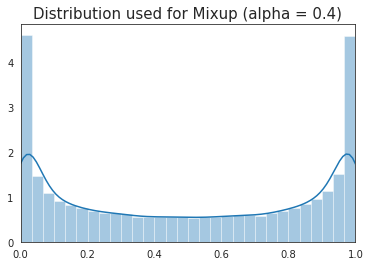

In [40]:
alpha_ = 0.4
sns.distplot(np.random.beta(alpha_, alpha_, 100000))
plt.xlim(0, 1)
plt.title(f'Distribution used for Mixup (alpha = {alpha_})', size=15)
plt.show()

In [41]:
def mixup_data(x, y, alpha=alpha_, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [42]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred.float().cuda(), y_a.float().cuda()) + (1 - lam) * criterion(pred.float().cuda(), y_b.float().cuda())

## Label Smoothing
We tried this as well, without any success. I do believe that clever use of label smoothing & noisy data can improve results

In [43]:
def smooth(y, eps=0.4):
    a = 1 - eps * (1 + 1/y.shape[1])
    b = eps / y.shape[1]
    return a * y + b

## Learning Rate
I reimplemented a custom Scheduler, that does Cosine Annealing and warmup. We found out that warmup played a quite important role

In [44]:
class WarmupCosineAnnealingLR(CosineAnnealingLR):
    def __init__(self, optimizer, warmup_prop, T_max, eta_min=0, last_epoch=-1):
        self.warmup_prop = warmup_prop
        super(CosineAnnealingLR, self).__init__(optimizer, T_max, eta_min, last_epoch)

    def get_lr(self):
        if self.last_epoch < T_max * warmup_prop:
            return [self.base_lrs * self.last_epoch/T_max
                    for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)]
        else:
            return super(CosineAnnealingLR, self).step()

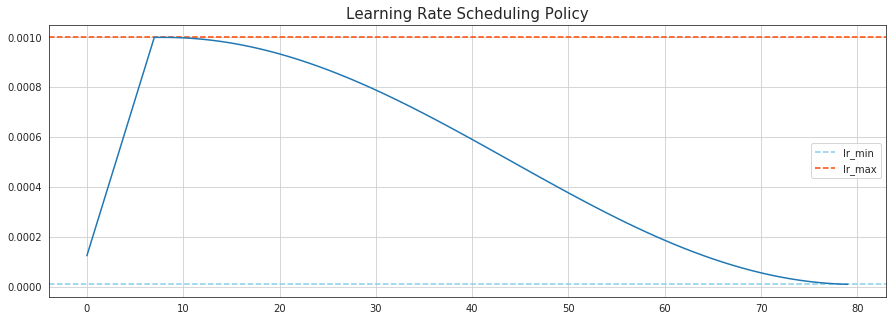

In [45]:
lr_max = 0.001
lr_min = 1e-5
warmup_prop = 0.1
nb_epochs = 80
epochs = [i for i in range(nb_epochs)]
lrs_warmup = [lr_max * i / (warmup_prop * nb_epochs) for i in range(1, int(warmup_prop * nb_epochs) + 1)]
lrs_scheduler = [lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(np.pi * i / ((1 - warmup_prop) * nb_epochs))) for i in range(int((1 - warmup_prop) * nb_epochs))]

plt.figure(figsize=(15, 5))
plt.axhline(lr_min, label='lr_min', c='skyblue', linestyle='--')
plt.axhline(lr_max, label='lr_max', c='orangered', linestyle='--')
plt.plot(epochs, lrs_warmup + lrs_scheduler[:len(epochs)])
plt.grid(True)
plt.legend()
plt.title('Learning Rate Scheduling Policy', size=15)
plt.show()

## Sigmoid

In [46]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Save & Load

In [47]:
def save_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'Saving weights to {filename}\n')
    torch.save(model.state_dict(), filename)

In [48]:
def load_model_weights(model, filename, verbose=1):
    if verbose:
        print(f'Loading weights from {filename}\n')
    model.load_state_dict(torch.load(filename))
    return model

## Predict

In [49]:
def predict(dataset, model, batch_size=64):
    model.eval()
    y = np.array([[]] * num_classes).T
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for x, target in loader:
            y = np.concatenate((y, sigmoid(model(x.cuda()).view(-1, num_classes).detach().cpu().numpy())))
    return y

## Fit
Code is a bit ugly, you might not want to dive into it. It's PyTorch. Here are the main points :

- Weight decay (0.001)
- Gradient clipping (1)
- Binary Cross Entropy loss
- Adam is used here, Adabound was also tried
- Custom lr scheduler (see above), with a warmup proportion 0.1 usually.
- Apply mixup with a probability *mixup* (chosen at 1)
- Checkpointing is used 


In [50]:
def fit(model, train_dataset, val_dataset, epochs=50, batch_size=128, nb_tta=5, mixup=False, warmup_prop=0.1,
        verbose=1, cp=False, model_name='model', lr=0.001):
    avg_val_loss = 1000
    best_score = 0
    clip_value = 1.0
    
    model.cuda()
    
    opt_params = [
        {'params': [p for n, p in list(model.named_parameters()) if not any(nd in n for nd in ['bias', 'LayerNorm.bias', 'LayerNorm.weight'])], 'weight_decay': 0.01},
        {'params': [p for n, p in list(model.named_parameters()) if any(nd in n for nd in ['bias', 'LayerNorm.bias', 'LayerNorm.weight'])], 'weight_decay': 0.0}
    ]

    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    
    optimizer = torch.optim.Adam(opt_params, lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-7)
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        

    if warmup_prop >= 1: 
        warmup_prop = warmup_prop / epochs

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  
        
        if epoch < epochs * warmup_prop:
            lr = 5e-5 + 0.001 * epoch / (epochs * warmup_prop)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        else:
            scheduler.step()
            lr = np.mean([param_group['lr'] for param_group in optimizer.param_groups])
        
        for x, y_batch in train_loader:
            optimizer.zero_grad()
            
            dice = np.random.random() < mixup
            if dice:
                x, y_a, y_b, lam = mixup_data(x, y_batch.float())
                x, y_a, y_b = map(Variable, (x, y_a, y_b))
    

            y_pred = model(x.cuda()).view(-1, num_classes)
            if dice:
                loss = mixup_criterion(loss_fn, y_pred, y_a, y_b, lam)
            else:
                loss = loss_fn(y_pred.float(), y_batch.float().cuda())
                
            loss.backward()
            avg_loss += loss.item() / len(train_dataset)
            optimizer.step()
    
        model.eval()
        avg_val_loss = 0.
        pred_val = np.array([[]]*num_classes).T
        
        for x, y_batch in val_loader:
            y_pred = model(x.cuda()).view(-1, num_classes).detach()
            avg_val_loss += loss_fn(y_pred.float(), y_batch.float().cuda()).item() / len(val_dataset)
            pred_val = np.concatenate((pred_val, sigmoid(y_pred.cpu().numpy())))
            
        pred_val = np.mean(pred_val.reshape((nb_tta, -1, num_classes,)), axis=0)
        score_class, weight = lwlrap(val_dataset.y, pred_val)
        score = (score_class * weight).sum()  
                
        elapsed_time = time.time() - start_time
        
        if cp:
            if score > best_score:
                save_model_weights(model, f"{model_name}.pt", verbose=0)
                best_score = score
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr={lr:.1e}     lwlrap={score:.5f}     ', end='')
            print(f'loss={avg_loss:.2f}     val_loss={avg_val_loss:.2f}     t={elapsed_time:.0f}s')
            
    return best_score

## Refit
- Same thing as the previous function, but:
 - We change the scheduler to reduce_lr_on_plateau, starting from 0.001
 - Used with curated data only

In [51]:
def refit(model, train_dataset, val_dataset, epochs=10, batch_size=128, nb_tta=5, mixup=False,
          verbose=1, cp=False, model_name='model', best_score=0, lr=0.001):
    avg_val_loss = 1000
    clip_value = 1.0
    
    model.cuda()
    
    opt_params = [
        {'params': [p for n, p in list(model.named_parameters()) if not any(nd in n for nd in ['bias', 'LayerNorm.bias', 'LayerNorm.weight'])], 'weight_decay': 0.01},
        {'params': [p for n, p in list(model.named_parameters()) if any(nd in n for nd in ['bias', 'LayerNorm.bias', 'LayerNorm.weight'])], 'weight_decay': 0.0}
    ]
    
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    
    optimizer = torch.optim.Adam(opt_params, lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=0)
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        start_time = time.time()  

        scheduler.step(avg_val_loss)
        lr = np.mean([param_group['lr'] for param_group in optimizer.param_groups])
        
        for x, y_batch in train_loader:
            optimizer.zero_grad()
            
            dice = np.random.random() < mixup
            if dice:
                x, y_a, y_b, lam = mixup_data(x, y_batch.float())
                x, y_a, y_b = map(Variable, (x, y_a, y_b))
    

            y_pred = model(x.cuda()).view(-1, num_classes)
            if dice:
                loss = mixup_criterion(loss_fn, y_pred, y_a, y_b, lam)
            else:
                loss = loss_fn(y_pred.float(), y_batch.float().cuda())
                
            loss.backward()
            avg_loss += loss.item() / len(train_dataset)
            optimizer.step()
    
        model.eval()
        avg_val_loss = 0.
        pred_val = np.array([[]]*num_classes).T
        
        for x, y_batch in val_loader:
            y_pred = model(x.cuda()).view(-1, num_classes).detach()
            avg_val_loss += loss_fn(y_pred.float(), y_batch.float().cuda()).item() / len(val_dataset)
            pred_val = np.concatenate((pred_val, sigmoid(y_pred.cpu().numpy())))
            
        pred_val = np.mean(pred_val.reshape((nb_tta, -1, num_classes,)), axis=0)
        score_class, weight = lwlrap(val_dataset.y, pred_val)
        score = (score_class * weight).sum()  
                
        elapsed_time = time.time() - start_time
        
        if cp:
            if score > best_score:
                save_model_weights(model, f"{model_name}.pt", verbose=0)
                best_score = score
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr={lr:.1e}     lwlrap={score:.5f}     ', end='')
            print(f'loss={avg_loss:.2f}     val_loss={avg_val_loss:.2f}     t={elapsed_time:.0f}s')
    
        if lr <= 1e-6:
            break
    return best_score

## $k$-folds
- 5 folds Stratified, using one of the labels if there are more. Only curated data is kept.
- Fit for 65 (approx.) epochs on curated + selected noisy (optional)
- Refit twice for a few epochs on curated only

In [52]:
def k_fold(model_class, X, y, X_test, transform_dic, X_noisy=[], y_noisy=np.array([]),
           k=5, batch_size=32, epochs=5, seed=2019, nb_tta=5, tta_eval=25, mixup=False,
           verbose=1, save=True, cp=False, warmup_prop=0.1, model_name="model", pretrained_path=''):
    
    splits = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=seed).split(X, np.argmax(y, axis=1)))
        
    pred_test = np.zeros((len(X_test), num_classes))
    pred_oof = np.zeros((y.shape[0], num_classes))

    for i, (train_idx, val_idx) in enumerate(splits):
        print(f"-------------   Fold {i+1}  -------------")
        seed_everything(seed + i)
        start_time = time.time()
        
        model = model_class(num_classes=num_classes)
        
        if len(pretrained_path):
            load_model_weights(model, pretrained_path)
        
        train_dataset = FATDatasetTrain([X[i] for i in train_idx] + X_noisy, transforms=transform_dic['train'], 
                                        y=np.concatenate((y[train_idx], y_noisy)),apply_spec_aug=True)
        val_dataset = FATDatasetTest([X[i] for i in val_idx], transforms=transform_dic['test'], y=y[val_idx], nb_tta=nb_tta)
        test_dataset = FATDatasetTest(X_test, transforms=transform_dic['test'], nb_tta=tta_eval)
        
        print('\n - Fitting \n')
        
        best_score = fit(model, train_dataset, val_dataset, epochs=epochs, batch_size=batch_size, nb_tta=nb_tta, mixup=mixup, 
                         warmup_prop=warmup_prop, verbose=verbose, cp=cp, model_name=f'{model_name}_{i+1}', lr=1e-3)
        
        print('\n - Re-fitting with curated data only (1/2)\n')
        
        retrain_dataset = FATDatasetTrain([X[i] for i in train_idx], transforms=transform_dic['train'], y=y[train_idx])
        
        best_score = refit(model, retrain_dataset, val_dataset, epochs=epochs, batch_size=batch_size, nb_tta=nb_tta, mixup=mixup, 
                           verbose=verbose, cp=cp, model_name=f'{model_name}_{i+1}', best_score=best_score, lr=1e-4)
        
        if cp:
            load_model_weights(model, f"{model_name}_{i+1}.pt", verbose=1)
        elif save:
            save_model_weights(model, f"{model_name}_{i+1}.pt", verbose=1)
        
        print('\n - Re-fitting with curated data only (2/2)\n')
        
        best_score = refit(model, retrain_dataset, val_dataset, epochs=epochs, batch_size=batch_size, nb_tta=nb_tta, mixup=mixup, 
                           verbose=verbose, cp=cp, model_name=f'{model_name}_{i+1}', best_score=best_score, lr=1e-4)
        
        if cp:
            load_model_weights(model, f"{model_name}_{i+1}.pt", verbose=1)
        elif save:
            save_model_weights(model, f"{model_name}_{i+1}.pt", verbose=1)
            
        print(f'\n - Predicting with {tta_eval} TTA \n')
        
        val_dataset = FATDatasetTest([X[i] for i in val_idx], transforms=transform_dic['test'], y=y[val_idx], nb_tta=tta_eval)
        pred_val = np.mean(predict(val_dataset, model).reshape((tta_eval, -1, num_classes,)), axis=0)
        pred_oof[val_idx, :] = pred_val
        
        score_class, weight = lwlrap(y[val_idx], pred_val)
        score = (score_class * weight).sum()
        
        pred_test += np.mean(predict(test_dataset, model).reshape((tta_eval, -1, num_classes,)), axis=0)

        
        print(f"\n lwlrap : Scored {score :.4f} on validation data")
        print(f"\n    Done in {(time.time() - start_time) / 60 :.1f} minutes \n")
        
    return pred_test, pred_oof

# Training

### Parameters

In [53]:
model_name = "model"
k = 5
epochs = 65
batch_size = 64
nb_tta = 5
mixup = 1
cp = True
warmup_prop = 0.1

In [54]:
model = Classifier_M3
transforms_ = transforms_dict

### Weights pretrained on noisy data
In case we want to use weights pretrained on noisy, we specify weights to load.

In [55]:
# cp_path = "../input/fat-cp/new_default_65.pt"
cp_path = ''

### Fitting

In [56]:
pred_test, pred_oof = k_fold(model, X_train, y_train, X_test, transforms_,
                             X_noisy=X_noisy, y_noisy=y_noisy, 
                             k=k, batch_size=batch_size, epochs=epochs, 
                             nb_tta=nb_tta, cp=cp, warmup_prop=warmup_prop,
                             mixup=mixup, seed=seed, 
                             model_name=model_name, pretrained_path=cp_path)

-------------   Fold 1  -------------

 - Fitting 

Epoch 1/65     lr=5.0e-05     lwlrap=0.26018     loss=55.27     val_loss=55.02     t=51s
Epoch 2/65     lr=2.0e-04     lwlrap=0.32222     loss=52.35     val_loss=47.70     t=51s
Epoch 3/65     lr=3.6e-04     lwlrap=0.26679     loss=34.57     val_loss=20.81     t=50s
Epoch 4/65     lr=5.1e-04     lwlrap=0.31297     loss=10.67     val_loss=5.44     t=50s
Epoch 5/65     lr=6.7e-04     lwlrap=0.36285     loss=5.08     val_loss=5.00     t=50s
Epoch 6/65     lr=8.2e-04     lwlrap=0.37723     loss=4.69     val_loss=4.69     t=50s
Epoch 7/65     lr=9.7e-04     lwlrap=0.43856     loss=4.48     val_loss=4.38     t=50s
Epoch 8/65     lr=1.0e-03     lwlrap=0.54052     loss=4.26     val_loss=3.80     t=50s
Epoch 9/65     lr=1.0e-03     lwlrap=0.60203     loss=4.01     val_loss=3.60     t=50s
Epoch 10/65     lr=1.0e-03     lwlrap=0.50895     loss=3.93     val_loss=4.25     t=50s
Epoch 11/65     lr=9.9e-04     lwlrap=0.61065     loss=3.86     val_lo

In [57]:
score_class, weight = lwlrap(y_train, pred_oof)
score = (score_class * weight).sum()

In [58]:
print(f'Local CV score is : {score:.4f}')

Local CV score is : 0.8703


In [59]:
score_df = pd.DataFrame(np.array([labels, np.round(score_class, 5), np.round(weight, 5)]).T, columns=['Label', 'Score', 'Weight']).set_index('Label').sort_values('Score')
score_df

,Score,Weight
Label,,
Walk_and_footsteps,0.61816,0.01305
Squeak,0.66539,0.01305
Fill_(with_liquid),0.685,0.0087
Buzz,0.7367,0.00975
Yell,0.73886,0.01305
Sink_(filling_or_washing),0.74065,0.01305
Traffic_noise_and_roadway_noise,0.74117,0.01305
Water_tap_and_faucet,0.74604,0.01305
Mechanical_fan,0.76589,0.00853


# Submission

In [60]:
df_test[df_test.columns[1:]] = pred_test

In [61]:
df_test.to_csv('submission.csv', index=False)